In [ ]:
# All the imports
!pip install patchify
!pip install GPUtil
!pip install torchsummary

from GPUtil import showUtilization as gpu_usage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import cv2
# import random
import glob
import PIL
from PIL import Image
from tqdm import tqdm
import imghdr
from patchify import patchify 


import time
import torch
import torchvision
import torch.optim as optim
import albumentations as A
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import Dropout
from torchsummary import summary

from torch.nn import BatchNorm2d 

from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch.nn.functional import normalize

- source_tutorial: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
- unet: https://github.com/milesial/Pytorch-UNet
- Probablistic_unet: https://github.com/stefanknegt/Probabilistic-Unet-Pytorch/blob/master/probabilistic_unet.py
- utility script: https://github.com/CaptainDredge/Image-segmentation-utilities
- GPU_utility: https://github.com/anderskm/gputil
- torch_em: https://github.com/computational-cell-analytics/dl-for-micro/blob/main/2_cell_segmentation/torchem-train-cell-membrane-segmentation.ipynb
- torch_em: https://github.com/constantinpape/torch-em/blob/main/torch_em/model/unet.py
- digital_sreeni: https://github.com/bnsreenu/python_for_microscopists/blob/master/206_sem_segm_large_images_using_unet_with_custom_patch_inference.py
- data_Augmentatin: https://albumentations.ai/docs/getting_started/mask_augmentation/
- learning rate https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling



### loss functionds
The validation loss function is just a metric and actually not needed for training. It's there because it make sense to compare the metrics which your network is actually optimzing on. So you can add any other loss function as metric during compilation and you'll see it during training.
- https://dev.to/_aadidev/3-common-loss-functions-for-image-segmentation-545o
- https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics/notebook
- https://github.com/JunMa11/SegLoss 
- https://pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/
- important for iunet loss and everytjing https://discuss.pytorch.org/t/unet-implementation/426/12

name coding: 
bSz2_1CH_ip128_vls20_ADM_EnDc32-1024_drp_ep10_aug4

- bsz: batch size
- lR: learning rate 1e-num
- SDG: optimiser
- ADM: Adam optimiser
- clcLR: scheduler 
- vls: validation split
- EnDc: encodert decoder channels
- pt: patience for earkly stopping
- i/p : input size 
- ep: epochs
- wd: weight decay(l2 reg)
- drp: drop out added
- 1CH: input one channel instead of RGB
- aug: num of augmentation

## Setting up configuration for running in notebooks

- The pin memory is set to True to the DataLoader which will automatically put the fetched data Tensors in pinned memory, enabling faster data transfer to CUDA-enabled GPU's. For every epoch the data is transferred from CPU to GPU, with augmentations done in the CPU, and trainings done in the GPU.
- Check the output directory for saving the images, model path, plot path and test path (BASE_OUTPUT, MODEL_PATH, PLOT_PATH, TEST_PATH)
- Note keep the bacthsize small (2,5) untill you start using pacthes of the image otherwise the GPU will run out of memory

In [ ]:
plotName = 'bSz2_1CH_ip128_vls20_ADM_EnDc32-1024_drp_ep10_aug4'
# define the test split
# TEST_SPLIT = 0.3
VALIDATION_SPLIT = 20

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
# PIN_MEMORY = True if DEVICE == "cuda" else False

# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
NUM_WORKERS = 2 if torch.cuda.is_available() else 1 

# initialize learning rate, number of epochs to train for, and the
# batch size ( in general small batch size has 256 samples, here due to 2 batch ss we have )
INIT_LR = 1e-3
NUM_EPOCHS = 20
BATCH_SIZE = 2
PATCH_SIZE = 128
WEIGHT_DECAY = 1e-6


# define the input image dimensions
# INPUT_IMAGE_WIDTH = 2048
# INPUT_IMAGE_HEIGHT = 1536

INPUT_IMAGE_WIDTH = PATCH_SIZE
INPUT_IMAGE_HEIGHT = PATCH_SIZE
# num_augmentations = 2
NUM_AUGMENTATION = 4

#learning rate scheduler 
Patience = 4
MAX_lr = 1e-1
BASE_lr = 1e-6
STEP_SIZE = 50

# define thresholds for early stopping, for accuracy calculation and predcitions 
EARLY_STOP_THRES = 3
best_accuracy = -1
best_epoch = -1
THRESHOLD = 0.5

BASE_OUTPUT = "/kaggle/working/"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_spheroid.pth")
# PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
# TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

# define the path to the base output directory
gpu_usage() 

## CREATING THE CUSTOM DATASET

In [ ]:
# Define paths to image and mask folders
imgs_path = '/kaggle/input/myofarm/images/'   #'/Users/sabyasachi/Documents/internship_data/images/'
file_list = glob.glob(imgs_path + "*")
print(file_list)
input_folder = file_list[0] #+ "/Images_input"
print(input_folder, len(input_folder))
mask_folder = file_list[1]# + "/Images_target"
print(mask_folder)

In [ ]:
def readData(imgPath, labelPath, convertType):
    """Reads and creates a list of target""" 
    image = []
    label = []
    imageList = []
    labelList = []
  
    for i, image_name in enumerate(sorted(os.listdir(imgPath))):
        if ((image_name.split('.')[1] == 'tif') or (image_name.split('.')[1] == 'tiff')):
            
            img_Path = os.path.join(imgPath, image_name)
            img = Image.open(img_Path).convert(convertType)
            # normalise by 255.0 -> convert to array -> append to list
            image.append(np.array(img, dtype = np.float32)/255.0)
            imageList.append(np.array(img_Path))
            
            label_name = '.'.join(image_name.split('.')[:-1]) +  '_bn.tif'
            label_Path = os.path.join(labelPath, label_name)
            img = Image.open(label_Path).convert(convertType)
            # convert to array -> binarise -> append to list
            label.append(np.where(np.array(img) >= 1, 1.0, 0.0)) 
            labelList.append(np.array(label_Path))
            
            
    return image, imageList, label, labelList
            
input_folder = '/kaggle/input/myofarm/images/Images_input'
label_folder = '/kaggle/input/myofarm/images/Images_target'
image, imageList, label, labelList = readData(input_folder, label_folder, convertType = 'L')   

image[0].shape, imageList[0], label[0].shape, labelList[0], image[0].max(), label[0].max()

In [ ]:
def plotSanityCheckImages(img1, img2):
    
    print(f'Images:{img1.shape} and mask:{img2.shape} shape\n')
    
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
    ax[0].imshow(img1)
    ax[1].imshow(img2, cmap = 'gray')
    ax[2].imshow(img2 * img1, cmap = 'gray')

    ax[0].set_title("Image with the original channel")
    ax[1].set_title("Original Mask")
    ax[2].set_title("combined and made gray")

    figure.tight_layout()
    figure.show()

plotSanityCheckImages(image[0], label[0])

In [ ]:
def prepare_plot(origImage, origMask, predMask):
#     print('prepare_plot predMask min and max:', predMask.min(), predMask.max())
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
    ax[0].imshow(origImage)
    ax[1].imshow(origImage * origMask)
    ax[2].imshow(origImage * predMask)

    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")

    figure.tight_layout()
    figure.show()

In [ ]:
# read about differet kinds of augmentations

def data_transform(image, mask):
    
    transform = A.Compose([
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ElasticTransform(p=0.5),
        A.GridDistortion(p = 0.5),
    ])
    
    # convert the images into array 
    # create a list
    image = np.float32(image)/255.0
    images_list = [np.array(image)]
    masks_list = [np.array(mask)]
    
#     for i in tqdm(range(4), desc="Augmenting Images"):
    for i in range(NUM_AUGMENTATION):
        augmentations = transform(image = np.array(image), mask = np.array(mask))
        augmented_img = augmentations["image"]
        augmented_mask = augmentations["mask"]
        images_list.append(augmented_img)
        masks_list.append(augmented_mask)
        
    return images_list, masks_list
    
print('To check the augmnetion patterns')

# img_Path = '/kaggle/input/myofarm/images/Images_input/20220912_JK_isRASb1_mc_p22_from_2.5_mio_220024_5uM_CHIR_dish2.tif'
# mask_Path = '/kaggle/input/myofarm/images/Images_target/20220912_JK_isRASb1_mc_p22_from_2.5_mio_220024_5uM_CHIR_dish2_bn.tif'
# # img_PIL = Image.open(img_Path).convert("RGB")
# mask_PIL = Image.open(mask_Path).convert("L")
    
# images_list, masks_list = data_transform(img_PIL, mask_PIL)

# for i, (img, mask) in enumerate(zip(images_list, masks_list)):
#         prepare_plot(img, mask, img*(mask.reshape(1536,2048,1)>0))


In [ ]:
def createPATCHES(imgList, maskList, PATCH_SIZE):
    images = []
    masks = []
    for i, (image, mask) in enumerate(zip(imgList, maskList)):      
        patch_images = patchify(image, (PATCH_SIZE,PATCH_SIZE), step = PATCH_SIZE)
        patch_masks = patchify(mask, (PATCH_SIZE,PATCH_SIZE), step = PATCH_SIZE)
        
        for i in range(patch_images.shape[0]):
            for j in range(patch_images.shape[1]):
                single_patch_img = patch_images[i,j,:,:]
                images.append(single_patch_img)
                
                single_patch_img = patch_masks[i,j,:,:]
                masks.append(single_patch_img)
                
    images = np.array(images)
    images = torch.reshape(torch.tensor(images), [-1,1,PATCH_SIZE,PATCH_SIZE])       
    masks = np.array(masks)
    masks = torch.reshape(torch.tensor(masks), [-1,1,PATCH_SIZE,PATCH_SIZE])
        
    return images, masks    
        

    
# image_patch, mask_patch = createPATCHES(images_list, masks_list,PATCH_SIZE )
    

Suppose NUM_AUGMENTATION is set to 15, and you have 10 original images in your dataset. So, the total number of items in the augmented dataset would be 10 * 15 = 150.

When idx is 25:
original_idx = 25 // 15 = 1
augmentation_idx = 25 % 15 = 10
This means the current index corresponds to the 10th augmentation of the 2nd original image.
When idx is 43:
original_idx = 43 // 15 = 2
augmentation_idx = 43 % 15 = 13
This means the current index corresponds to the 13th augmentation of the 3rd original image.


he createPATCHES function likely processes multiple images and masks at once. By passing [augmented_img] and [augmented_mask] (which are lists), you're providing the function with the necessary format for handling multiple images and masks, even though in this case, you're passing only one of each.

In [ ]:
class SpheroidDataset(Dataset):
    
    def __init__(self, imagePaths, maskPaths, transforms, num_augmentations = NUM_AUGMENTATION):
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        self.num_augmentations = NUM_AUGMENTATION

#         Get list of image and target file paths
        self.imageFiles = sorted(os.listdir(imagePaths))
        self.maskFiles = sorted(os.listdir(maskPaths))
        

    def __len__(self):
        # Calculate the new length of the dataset
        original_length = len(self.imageFiles)
        augmented_length = original_length * self.num_augmentations
        return augmented_length
    
    
    def __getitem__(self, idx):
        # getitem iterates through the files and gets the index as well
        
        # Calculate the original index and augmentation index
        original_idx = idx // self.num_augmentations
        augmentation_idx = idx % self.num_augmentations

        # grab the image name from the current index  
        # Read the image perform augmentation 
        imagePath = self.imageFiles[original_idx]
#         print('here verify the image name', imagePath)
        if imagePath == '.DS_Store':
            idx += 1
            imagePath = self.imageFiles[original_idx]
        img_Path = os.path.join(self.imagePaths, imagePath)
        img_PIL = Image.open(img_Path).convert("L")
        
        maskPath = '.'.join(imagePath.split('.')[:-1]) + '_bn.tif'
        mask_Path = os.path.join(self.maskPaths,maskPath)
#         mask_PIL = Image.open(mask_Path).convert("L")
        mask = np.array(Image.open(mask_Path).convert("L"), dtype=np.float32)
#         mask[mask > 0.1] = 1.0
        mask = np.where(mask>=1, 1.0, 0.0)
        
        images_list, masks_list = data_transform(img_PIL, mask)
         # Retrieve the augmented image and mask for the current augmentation index
        augmented_img = images_list[augmentation_idx]
        augmented_mask = masks_list[augmentation_idx]
        
#         image_patch, mask_patch = createPATCHES(images_list, masks_list,PATCH_SIZE )
        image_patch, mask_patch = createPATCHES([augmented_img], [augmented_mask],PATCH_SIZE )
        
               
        return image_patch, mask_patch, img_Path, mask_Path, imagePath, maskPath 

gpu_usage() 

dataset = SpheroidDataset(input_folder, mask_folder, transforms = None)


for images, masks, img_Path, mask_Path, imagePath, maskPath in dataset:    
    print(images.shape) #print path and others also for checking
    print(torch.min(images), torch.mean(images), torch.max(images))
    print(masks.shape)
    print('\n')
    break
    
len(dataset)

## Check Point Early stopping 

In [ ]:
# this is for the full model saving 
def save_checkpoint(state, filename):
    print("=> Saving complete model ")
    torch.save(state, filename)
    
# this is just to save the model parameters not very comprehensive
def checkpoint(model, filename):
    print("=> Saving all model parameters ")
    torch.save(model.state_dict(), filename)

## LOSS Functions and Accuracy metric


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [ ]:
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [ ]:
#PyTorch
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [ ]:
def accuracy(preds, targets, threshold=0.5):
    # Apply threshold to predicted masks
    preds = (preds > threshold).float()
    
    # Flatten the tensors
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    # Calculate pixel-wise accuracy
    correct = (preds == targets).float()
    acc = correct.sum() / targets.numel()
    
    return acc

## Building UNET

- Overall, our U-Net model will consist of an Encoder class and a Decoder class. The encoder will gradually reduce the spatial dimension to compress information. Furthermore, it will increase the number of channels, that is, the number of feature maps at each stage, enabling our model to capture different details or features in our image. On the other hand, the decoder will take the final encoder representation and gradually increase the spatial dimension and reduce the number of channels to finally output a segmentation mask of the same spatial dimension as the input image.

- Next, we define a Block module as the building unit of our encoder and decoder architecture. It is worth noting that all models or model sub-parts that we define are required to inherit from the PyTorch Module class, which is the parent class in PyTorch for all neural network modules.

### Creating the model 
- here mutiple kind of experimenst can be done taking inspiratin from cellpose

In [ ]:
class Block(Module):
    """(convolution => [BN] => ReLU) * 2"""
    """ Note make sure to change the i/p channel to later on"""
    
    def __init__(self, inChannels, outChannels):#, mid_channels=None):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = nn.Conv2d(inChannels, outChannels,
                            kernel_size=3, stride=1, padding=1, bias=True)
        self.BN1 = nn.BatchNorm2d(outChannels)
        self.relu1 = nn.ReLU(inplace = True)
        self.dropout = nn.Dropout(0.25)
            
        self.conv2 = Conv2d(outChannels, outChannels, 
                            kernel_size=3, stride=1, padding=1, bias=True)
        self.BN2 = BatchNorm2d(outChannels)
        self.relu2 = ReLU(inplace = True)
        
    def forward(self, x):
        # apply CONV => [BN] => RELU => CONV block to the inputs and return it
        outputConv1 = self.dropout(self.relu1(self.BN1(self.conv1(x))))
        outputConv2 = self.relu2(self.BN2(self.conv2(outputConv1)))
        #self.conv2(self.relu(self.BN(self.conv1(x))))
        
        return outputConv2
    
# Block()

In [ ]:
class Encoder(Module):
    """ Note make sure to change the i/p channel to later on ( #(1, 32, 64, 128, 256, 512))"""
    
    def __init__(self, channels=(1, 32, 64, 128, 256, 512)): 
        super().__init__()
        # using the block code to get the decoder conv blocks and maxpooling layer
        self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) 
                                      for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(kernel_size=2, stride=2)

        
    def forward(self, x):
        # this takes an input image x
        # initialize an empty list to store the intermediate outputs
        # Note that this will enable us to later pass these outputs
        # to that decoder where they can be processed with the decoder feature maps.
        blockOutputs = []
        
        # loop through the encoder blocks 
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs in blockOutputs list, and then apply maxpooling on the output
            x = block(x)
#             print("Encoder -forward input shape:", x.shape)
            blockOutputs.append(x)
            x = self.pool(x)
#             print("Encoder -forward output shape:", x.shape)
        # return the list containing the intermediate outputs
        return blockOutputs
    
    

# to check    
# Encoder()

In [ ]:
class Decoder(Module):
    def __init__(self, channels=(512, 256, 128, 64, 32)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and decoder blocks
        self.channels = channels
        
        # note the ConvTranspose2d,unlike our block earlier in encoding, 
        # is part of the nn torch module imported earlier
        self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2)
                                   for i in range(len(channels) - 1)])

        # using the block code to get the decoder conv blocks 
        self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1])
                                       for i in range(len(channels) - 1)])
    
        # forward for the decoder section 
        # which takes as input our feature map x and 
        # the list of intermediate outputs from the encoder (i.e., encFeatures).
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            # encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeatures[i]], dim=1)
            x = self.dec_blocks[i](x)
#             print(x.shape)
        # return the final decoder output
        return x   

# to chevk    
# Decoder()


- nbClasses: This defines the number of segmentation classes where we have to classify each pixel. This usually corresponds to the number of channels in our output segmentation map, where we have one channel for each class. Since we are working with two classes (i.e., binary classification), we keep a single channel and use thresholding for classification, as we will discuss later.

- Now the encFeatures[::-1] list contains the feature map outputs in reverse order (i.e., from the last to the first encoder block). Note that this is important since, on the decoder side, we will be utilizing the encoder feature maps starting from the last encoder block output to the first.

In [ ]:
class UNet(Module):
    """ Note make sure to change the i/p channel to later on ( #(1, 16, 32, 64, 128, 256, 512))"""
        
    def __init__(self, encChannels=(1, 16, 32, 64, 128, 256, 512),
                 decChannels=(512, 256, 128, 64, 32, 16), 
                 nbClasses=1, retainDim=True,
                 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
                 # outSize=(config.INPUT_IMAGE_HEIGHT,  config.INPUT_IMAGE_WIDTH)): if the config block converted into a utility file 
        super().__init__()
        
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        
        # initialize the regression head and store the class variables: the final layer
#         self.head = Conv2d(decChannels[-1], nbClasses, 1)
        
        self.head = nn.Sequential(
                        nn.Conv2d(decChannels[-1], nbClasses, kernel_size=1),
                        nn.Sigmoid()
                        )
        self.retainDim = retainDim
        self.outSize = outSize
        
        
    def forward(self, x):
        # grab the features from the encoder
        # Note that the encFeatures list contains 
        # all the feature maps starting from the first encoder block output to the last
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        # since the encoder feature maps starting from the last encoder block output to the first of the decoder
       
        # output of the final encoder block 
        # (i.e., encFeatures[::-1][0]) and the feature map outputs of all intermediate encoder blocks 
        # (i.e., encFeatures[::-1][1:]) to the decoder 
        decFeatures = self.decoder(encFeatures[::-1][0],
                                   encFeatures[::-1][1:])
        
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return map


In [ ]:
summary(UNet().to(DEVICE), input_size=(1,PATCH_SIZE,PATCH_SIZE))

In [ ]:
UNet().to(DEVICE)

## Train the UNET model

- ToPILImage(): it enables us to convert our input images to PIL image format. Note that this is necessary since we used OpenCV to load images in our custom dataset, but PyTorch expects the input image samples to be in PIL format.
- Resize(): allows us to resize our images to a particular input dimension (i.e., config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH) that our model can accept
- ToTensor(): enables us to convert input images to PyTorch tensors and convert the input PIL Image, which is originally in the range from [0, 255], to [0, 1].


In [ ]:
# BATCH_SIZE = 5
# VALIDATION_SPLIT = 20
train_dataset = SpheroidDataset(input_folder, mask_folder, transforms = None)
train_set, validation_set = torch.utils.data.random_split(train_dataset, 
                                                          [len(train_dataset) - len(train_dataset)//VALIDATION_SPLIT, 
                                                           len(train_dataset)//VALIDATION_SPLIT])
trainLoader = DataLoader(dataset = train_set, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle =True)
validationLoader = DataLoader(dataset = validation_set, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle =True) 

print(f"Total {len(train_set)} examples in the training set")
print(f"Total {len(validation_set)} examples in the validation set")
print(f"Total number of train sets: {len(trainLoader)},and validation loader {len(validationLoader)}")

gpu_usage() 

In [ ]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizerimizer
metric_lossFunc = DiceBCELoss() #nn.BCELoss() #DiceLoss()
optimizer = optim.Adam(unet.parameters(), lr= INIT_LR, weight_decay = WEIGHT_DECAY)
# optimizer = torch.optim.SGD(unet.parameters(), lr=INIT_LR, momentum=0.9, weight_decay = WEIGHT_DECAY)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor= 0.1, patience=Patience, verbose = True)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, cycle_momentum = True, verbose = True)
# calculate steps per epoch for training and test set
trainSteps = len(train_set) // BATCH_SIZE
testSteps = len(validation_set) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "validation_loss": [], "model_accuracy":[]}



In [ ]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for epoch in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode - initialise train and val loss - loop on train set
    unet.train()
    totalTrainLoss = 0
    totalValidationLoss_model = 0
    totalValidationLoss_metric = 0
    gpu_usage() 
    for (i, (x, y, img_Path, mask_Path, imagePath, maskPath)) in enumerate(trainLoader):
        # send the input to the device - forward pass - train loss - zero out prev gradients 
        # - back propagation - update model params - add train loss (.item makes it float)
        #""" Note make sure to change the i/p channel to later on ([-1, 1, patch_size, patch_size])"""
        x = torch.reshape(x,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
        y = torch.reshape(y,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        #print(x.shape)
        pred = unet(x) 
        loss = metric_lossFunc(pred.to(torch.float32), y.to(torch.float32))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        totalTrainLoss += loss.item()
        
    # switch off autograd
    # Beging the validation set - inputs to device - val loss calculations
    with torch.no_grad():
        unet.eval()
        for (x, y, img_Path, mask_Path, imagePath, maskPath) in validationLoader:
            """ Note make sure to change the i/p channel to later on ([-1, 1, patch_size, patch_size])"""
            x = torch.reshape(x,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
            y = torch.reshape(y,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            pred = unet(x)
            totalValidationLoss_metric += metric_lossFunc(pred.to(torch.float32), y.to(torch.float32)).item()
            acc = accuracy(pred.to(torch.float32), y.to(torch.float32)).item()
    # calculate the average training and validation loss and binary accuracy
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValidationLoss = totalValidationLoss_metric / testSteps
    avgAcc = acc / testSteps
    
    H["train_loss"].append(avgTrainLoss)
    H["validation_loss"].append(avgValidationLoss) 
    H["model_accuracy"].append(avgAcc) 
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Validation loss: {:.4f},Val accuracy: {:.2f}%".format(avgTrainLoss, 
                                                                                     avgValidationLoss, 
                                                                                     avgAcc))
    
    # terminate the training loop
#     if avgAcc > best_accuracy:
#         best_accuracy = avgAcc
#         best_epoch = epoch
#         checkpoint(unet, MODEL_PATH)
#     elif epoch - best_epoch > EARLY_STOP_THRES:
#         print("Early stopped training at epoch %d" % epoch)
#         break  
    
    # Step the scheduler based on training loss 
#     scheduler.step(avgTrainLoss)
    # Step the scheduler based on validation loss 
#     scheduler.step(avgValidationLoss)
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

In [ ]:
# H['train_loss']
gpu_usage()

NameError: name 'torch' is not defined

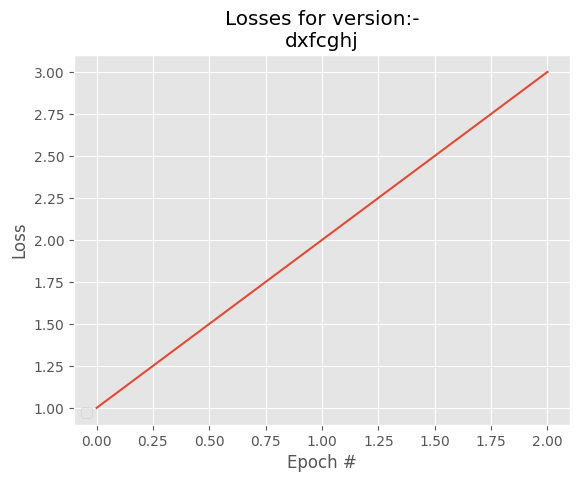

In [14]:
import matplotlib.pyplot as plt

# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["validation_loss"], label="validation_loss")
plt.plot(H["avgAcc"], label="accuracy")
plt.title(f"Losses for version:-\n{plotName}")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
# plt.savefig(config.PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

# Model used for prediction of segemnted images

In [ ]:

def prepare_plot(origImage, origMask, predMask, threshold = None):
#     print('prepare_plot predMask min and max:', predMask.min(), predMask.max())
    # initialize our figure
    print(threshold)
    figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    ax[3].imshow(predMask > (predMask.max() - threshold))
#     ax[3].hist(predMask.flatten()*255)

    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("P_Mask w/o thresh")
    ax[3].set_title('P_mask w threshold')

    figure.tight_layout()
    figure.show()

In [ ]:
def make_predictions(model, imagePath, groundTruthPath, patch_size, threshold = None):
    model.eval()
    with torch.no_grad():
        image = Image.open(imagePath).convert("L")
        image = np.float32(image)/255.0
        
        gtMask = np.array(Image.open(groundTruthPath).convert("L"))
        gtMask[gtMask > 0] = 1.0
    
        height, width = image.shape[:2]
        segm_img = np.zeros((height, width), dtype=np.uint8)  # Array with zeros to be filled with segmented values
    
        patch_num = 1
    
        for i in range(0, height, patch_size):  
            for j in range(0, width, patch_size):  
                single_patch = image[i:i+patch_size, j:j+patch_size]
                single_patch = np.expand_dims(single_patch, 0)
                single_patch = np.expand_dims(single_patch, 0)
                orig_patch = single_patch.copy()
                single_patch = torch.from_numpy(single_patch).to(DEVICE)
                
                Mask_patch = gtMask[i:i+patch_size, j:j+patch_size]
               
                # make the prediction, pass the results through the sigmoid
                # function, and convert the result to a NumPy array
                single_patch_prediction = torch.sigmoid(model(single_patch)).squeeze().cpu().numpy()
                
                # filter out the weak predictions and convert them to integers
                single_patch_prediction = (single_patch_prediction*255.0).astype(np.uint8)
                
                
                single_patch_shape = single_patch_prediction.shape[:2]
                segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(single_patch_prediction, single_patch_shape[::-1])
            
            print("Finished processing patch number ", patch_num, " at position ", i, j)
            print('\nmax value:-->', single_patch_prediction.max(),'\nmin value:-->', single_patch_prediction.min() )
            patch_num += 1
            
    prepare_plot(image, gtMask, segm_img,threshold)
    return single_patch_prediction#, segm_img

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)

print("[INFO] loading up test image paths...")
files = np.random.choice(os.listdir(input_folder), size = 1)
imagePaths = []


for file in files:
    imagePath = input_folder+ '/' + file
    groundTruthPath = mask_folder + '/' + '.'.join(file.split('.')[:-1]) + '_bn.tif'
    print(imagePath, groundTruthPath)
    simg = make_predictions(unet, imagePath, groundTruthPath, PATCH_SIZE, threshold = 2)



# img = simg.copy()

# print( img.shape,img.dtype, img.max(), img.min())
# plt.imshow(img>(img.max() - 1.5))
# plt.hist(img.flatten())